<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to Landlab: Creating a simple 2D scarp diffusion model

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>


This tutorial illustrates how you can use Landlab to construct a simple two-dimensional numerical model on a regular (raster) grid, using a simple forward-time, centered-space numerical scheme. The example is the erosional degradation of an earthquake fault scarp, and which evolves over time in response to the gradual downhill motion of soil. Here we use a simple "geomorphic diffusion" model for landform evolution, in which the downhill flow of soil is assumed to be proportional to the (downhill) gradient of the land surface multiplied by a transport coefficient.

We start by importing the [numpy](https://numpy.org) and [matplotlib](https://matplotlib.org) libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Part 1: 1D version using numpy

This example uses a finite-volume numerical solution to the 2D diffusion equation. The 2D diffusion equation in this case is derived as follows. Continuity of mass states that:

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$,

where $z$ is elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, and $\nabla$ is the divergence operator (here in two dimensions). (Note that we have omitted a porosity factor here; its effect will be subsumed in the transport coefficient). The sediment flux vector depends on the slope gradient:

$\mathbf{q}_s = -D \nabla z$,

where $D$ is a transport-rate coefficient---sometimes called *hillslope diffusivity*---with dimensions of length squared per time. Combining the two, and assuming $D$ is uniform, we have a classical 2D diffusion equation:

$\frac{\partial z}{\partial t} = -\nabla^2 z$.

In this first example, we will create a our 1D domain in $x$ and $z$, and set a value for $D$.

This means that the equation we solve will be in 1D. 

$\frac{d z}{d t} = \frac{d q_s}{dx}$,

where 

$q_s = -D \frac{d z}{dx}$


In [2]:
dx = 1
x = np.arange(0, 100, dx, dtype=float)
z = np.zeros(x.shape, dtype=float)
D = 0.01

Next we must create our fault by uplifting some of the domain. We will increment all elements of `z` in which `x>50`.

In [3]:
z[x > 50] += 100

Finally, we will diffuse our fault for 1,000 years.

We will use a timestep with a [Courant–Friedrichs–Lewy condition](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition) of $C_{cfl}=0.2$. This will keep our solution numerically stable. 

$C_{cfl} = \frac{\Delta t D}{\Delta x^2} = 0.2$

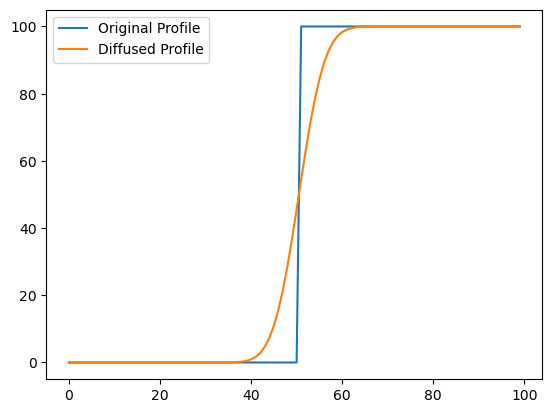

In [4]:
dt = 0.2 * dx * dx / D
total_time = 1e3
nts = int(total_time / dt)
z_orig = z.copy()
for i in range(nts):
    qs = -D * np.diff(z) / dx
    dzdt = -np.diff(qs) / dx
    z[1:-1] += dzdt * dt

plt.plot(x, z_orig, label="Original Profile")
plt.plot(x, z, label="Diffused Profile")
plt.legend()

The prior example is pretty simple. If this was all you needed to do, you wouldn't need Landlab. 

But what if you wanted...

... to use the same diffusion model in 2D instead of 1D.

... to use an irregular grid (in 1 or 2D). 

... wanted to combine the diffusion model with a more complex model. 

... have a more complex model you want to use over and over again with different boundary conditions.

These are the sorts of problems that Landlab was designed to solve. 

In the next two sections we will introduce some of the core capabilities of Landlab. 

In Part 2 we will use the RasterModelGrid, fields, and a numerical utility for calculating flux divergence. 

In Part 3 we will use the HexagonalModelGrid. 

In Part 4 we will use the LinearDiffuser component. 

## Part 2: 2D version using Landlab's Model Grids

The Landlab model grids are data structures that represent the model domain (the variable `x` in our prior example). Here we will use `RasterModelGrid` which creates a grid with regularly spaced square grid elements. The RasterModelGrid knows how the elements are connected and how far apart they are.

Lets start by creating a RasterModelGrid class. First we need to import it. 

In [5]:
from landlab import RasterModelGrid


### (a) Explore the RasterModelGrid

Before we make a RasterModelGrid for our fault example, lets explore the Landlab model grid. 

Landlab considers the grid as a "dual" graph. Two sets of points, lines and polygons that represent 2D space. 

The first graph considers points called "nodes" that are connected by lines called "links". The area that surrounds each node is called a "cell".

First, the nodes

<Axes: xlabel='x', ylabel='y'>

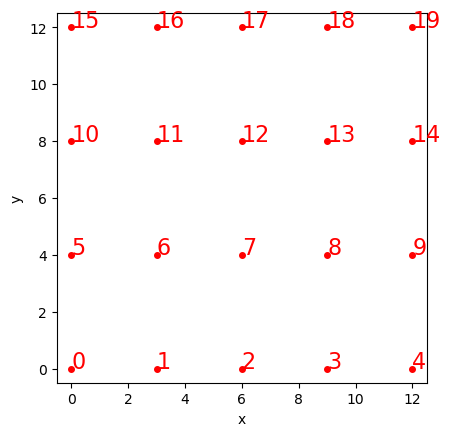

In [6]:
from landlab.plot.graph import plot_graph

grid = RasterModelGrid((4, 5), xy_spacing=(3, 4))
plot_graph(grid, at="node")

You can see that the nodes are points and they are numbered with unique IDs from lower left to upper right. 

Next the links

<Axes: xlabel='x', ylabel='y'>

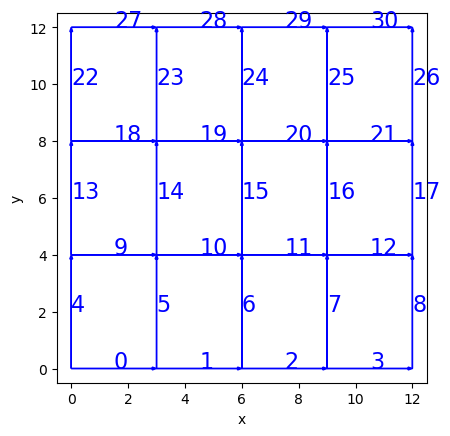

In [7]:
plot_graph(grid, at="link")

which are lines that connect the nodes and each have a unique ID number. 

And finally, the cells

<Axes: xlabel='x', ylabel='y'>

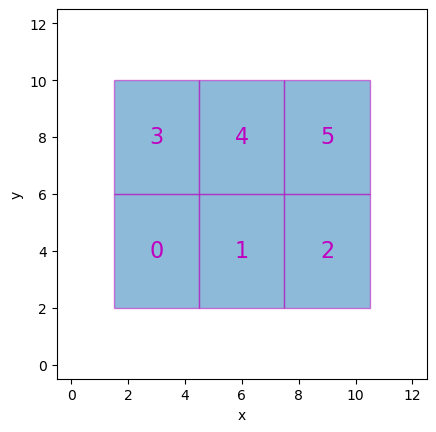

In [8]:
plot_graph(grid, at="cell")

which are polygons centered around the nodes. 

Landlab is a "dual" graph because it also keeps track of a second set of points, lines, and polygons ("corners", "faces", and "patches"). We will not focus on them further.

### (b) Use the RasterModelGrid for 2D diffusion 

Lets continue by making a new grid that is bigger. We will use this for our next fault diffusion example.

The syntax in the next line says: create a new *RasterModelGrid* object called **mg**, with 25 rows, 40 columns, and a grid spacing of 10 m.

In [9]:
mg = RasterModelGrid((25, 40), 10.0)

Note the use of object-oriented programming here. `RasterModelGrid` is a class; `mg` is a particular instance of that class, and it contains all the data necessary to fully describe the topology and geometry of this particular grid.

Next we'll add a *data field* to the grid, to represent the elevation values at grid nodes. The "dot" syntax below indicates that we are calling a function (or *method*) that belongs to the *RasterModelGrid* class, and will act on data contained in **mg**. The arguments indicate that we want the data elements attached to grid nodes (rather than links, for example), and that we want to name this data field `topographic__elevation`. The `add_zeros` method returns the newly created NumPy array.

In [10]:
z = mg.add_zeros("topographic__elevation", at="node")

The above line of code creates space in memory to store 1,000 floating-point values, which will represent the elevation of the land surface at each of our 1,000 grid nodes.

Let's plot the positions of all the grid nodes. The nodes' *(x,y)* positions are stored in the arrays `mg.x_of_node` and `mg.y_of_node`, respectively.

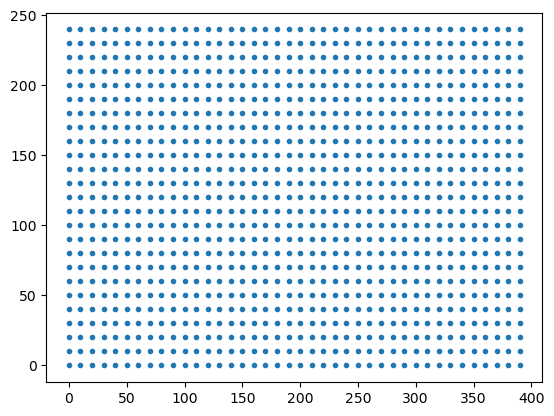

In [11]:
plt.plot(mg.x_of_node, mg.y_of_node, ".")

If we bothered to count, we'd see that there are indeed 1,000 grid nodes, and a corresponding number of `z` values:

In [12]:
len(z)

1000

Now for some tectonics. Let's say there's a fault trace that angles roughly east-northeast. We can describe the trace with the equation for a line. One trick here: by using `mg.x_of_node`, in the line of code below, we are calculating a *y* (i.e., north-south) position of the fault trace for each grid node---meaning that this is the *y* coordinate of the trace at the *x* coordinate of a given node.

In [13]:
fault_trace_y = 50.0 + 0.25 * mg.x_of_node

Here comes the earthquake. For all the nodes north of the fault (i.e., those with a *y* coordinate greater than the corresponding *y* coordinate of the fault trace), we'll add elevation equal to 10 meters plus a centimeter for every meter east along the grid (just to make it interesting):

In [14]:
z[mg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]
)

(A little bit of Python under the hood: the statement `mg.y_of_node > fault_trace_y` creates a 1000-element long boolean array; placing this within the index brackets will select only those array entries that correspond to `True` in the boolean array)

Let's look at our newly created initial topography using Landlab's *imshow_node_grid* plotting function (which we first need to import).

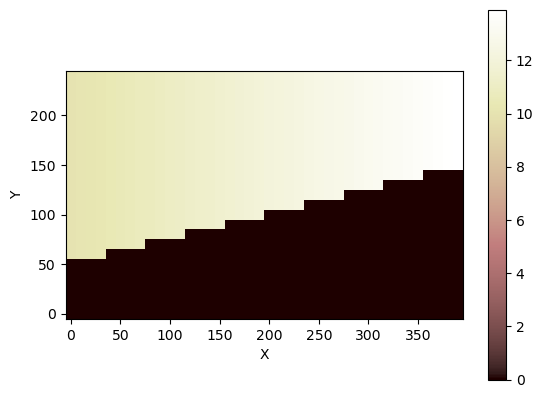

In [15]:
from landlab.plot.imshow import imshow_grid

imshow_grid(mg, "topographic__elevation")

To finish getting set up, we will define two parameters: the transport ("diffusivity") coefficient, `D`, and the time-step size, `dt`. (The latter is set using the Courant condition for a forward-time, centered-space finite-difference solution; you can find the explanation in most textbooks on numerical methods).

In [16]:
D = 0.01  # m2/yr transport coefficient
dt = 0.2 * mg.dx * mg.dx / D
dt

2000.0

Boundary conditions: for this example, we'll assume that the east and west sides are closed to flow of sediment, but that the north and south sides are open. (The order of the function arguments is east, north, west, south)

In [17]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

*A note on boundaries:* with a Landlab raster grid, all the perimeter nodes are boundary nodes. In this example, there are 24 + 24 + 39 + 39 = 126 boundary nodes. The previous line of code set those on the east and west edges to be **closed boundaries**, while those on the north and south are **open boundaries** (the default). All the remaining nodes are known as **core** nodes. In this example, there are 1000 - 126 = 874 core nodes:

In [18]:
len(mg.core_nodes)

874

One more thing before we run the time loop: we'll create an array to contain soil flux. In the function call below, the first argument tells Landlab that we want one value for each grid link, while the second argument provides a name for this data *field*:

In [19]:
qs = mg.add_zeros("sediment_flux", at="link")

And now for some landform evolution. We will loop through 25 iterations, representing 50,000 years. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the gradient between each neighboring pair of nodes. These calculations are done on **links**. The gradient value is a positive number when the gradient is "uphill" in the direction of the link, and negative when the gradient is "downhill" in the direction of the link. On a raster grid, link directions are always in the direction of increasing $x$ ("horizontal" links) or increasing $y$ ("vertical" links).

2. Calculate, and store in the array `qs`, the sediment flux between each adjacent pair of nodes by multiplying their gradient by the transport coefficient. We will only do this for the **active links** (those not connected to a closed boundary, and not connecting two boundary nodes of any type); others will remain as zero.

3. Calculate the resulting net flux at each node (positive=net outflux, negative=net influx). The negative of this array is the rate of change of elevation at each (core) node, so store it in a node array called `dzdt'.

4. Update the elevations for the new time step.

In [20]:
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt

Let's look at how our fault scarp has evolved.

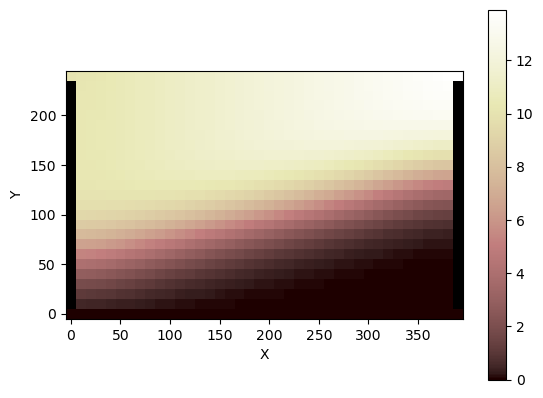

In [21]:
imshow_grid(mg, "topographic__elevation")

Notice that we have just created and run a 2D model of fault-scarp creation and diffusion with fewer than two dozen lines of code. How long would this have taken to write in C or Fortran?

While it was very very easy to write in 1D, writing this in 2D would mean we would have needed to keep track of the adjacency of the different parts of the grid. This is the primary problem that the Landlab grids are meant to solve. 

Think about how difficult this would be to hand code if the grid were irregular or hexagonal. In order to conserve mass and implement the differential equation you would need to know how nodes were conected, how long the links were, and how big each cell was.

We do such an example after the next section. 

### (c) What's going on under the hood?

This example uses a finite-volume numerical solution to the 2D diffusion equation. The 2D diffusion equation in this case is derived as follows. Continuity of mass states that:

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$,

where $z$ is elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, and $\nabla$ is the divergence operator (here in two dimensions). (Note that we have omitted a porosity factor here; its effect will be subsumed in the transport coefficient). The sediment flux vector depends on the slope gradient:

$\mathbf{q}_s = -D \nabla z$,

where $D$ is a transport-rate coefficient---sometimes called *hillslope diffusivity*---with dimensions of length squared per time. Combining the two, and assuming $D$ is uniform, we have a classical 2D diffusion equation:

$\frac{\partial z}{\partial t} = -\nabla^2 z$.

For the numerical solution, we discretize $z$ at a series of *nodes* on a grid. The example in this notebook uses a Landlab *RasterModelGrid*, in which every interior node sits inside a cell of width $\Delta x$, but we could alternatively have used any grid type that provides nodes, links, and cells.

The gradient and sediment flux vectors will be calculated at the *links* that connect each pair of adjacent nodes. These links correspond to the mid-points of the cell faces, and the values that we assign to links represent the gradients and fluxes, respectively, along the faces of the cells.

The flux divergence, $\nabla \mathbf{q}_s$, will be calculated by summing, for every cell, the total volume inflows and outflows at each cell face, and dividing the resulting sum by the cell area. Note that for a regular, rectilinear grid, as we use in this example, this finite-volume method is equivalent to a finite-difference method.

To advance the solution in time, we will use a simple explicit, forward-difference method. This solution scheme for a given node $i$ can be written:

$\frac{z_i^{t+1} - z_i^t}{\Delta t} = -\frac{1}{A_i} \sum\limits_{j=1}^{N_i} \delta (l_{ij}) q_s (l_{ij}) \lambda(l_{ij})$.

Here the superscripts refer to time steps, $\Delta t$ is time-step size, $q_s(l_{ij})$ is the sediment flux per width associated with the link that crosses the $j$-th face of the cell at node $i$, $\lambda(l_{ij})$ is the width of the cell face associated with that link ($=\Delta x$ for a regular uniform grid), and $N_i$ is the number of active links that connect to node $i$. The variable $\delta(l_{ij})$ contains either +1 or -1: it is +1 if link $l_{ij}$ is oriented away from the node (in which case positive flux would represent material leaving its cell), or -1 if instead the link "points" into the cell (in which case positive flux means material is entering).

To get the fluxes, we first calculate the *gradient*, $G$, at each link, $k$:

$G(k) = \frac{z(H_k) - z(T_k)}{L_k}$.

Here $H_k$ refers the *head node* associated with link $k$, $T_k$ is the *tail node* associated with link $k$. Each link has a direction: from the tail node to the head node. The length of link $k$ is $L_k$ (equal to $\Delta x$ is a regular uniform grid). What the above equation says is that the gradient in $z$ associated with each link is simply the difference in $z$ value between its two endpoint nodes, divided by the distance between them. The gradient is positive when the value at the head node (the "tip" of the link) is greater than the value at the tail node, and vice versa.

The calculation of gradients in $z$ at the links is accomplished with the `calc_grad_at_link` function. The sediment fluxes are then calculated by multiplying the link gradients by $-D$. Once the fluxes at links have been established, the `calc_flux_div_at_node` function performs the summation of fluxes.

## Part 3: Hexagonal grid

Next we will use an non-raster Landlab grid.

We start by making a random set of points with x values between 0 and 400 and y values of 0 and 250. We then add zeros to our grid at a field called "topographic__elevation" and plot the node locations. 

Note that the syntax here is exactly the same as in the RasterModelGrid example (once the grid has been created).

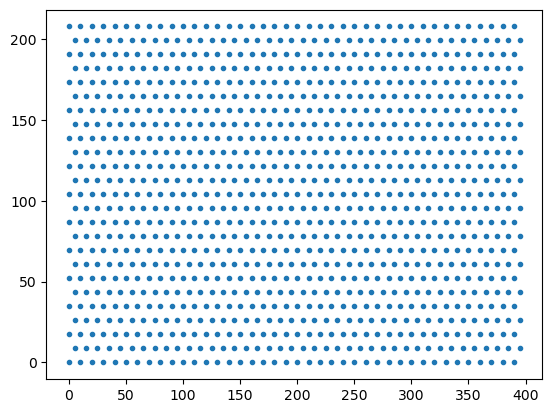

In [22]:
from landlab import HexModelGrid

mg = HexModelGrid((25, 40), 10, node_layout="rect")
z = mg.add_zeros("topographic__elevation", at="node")
plt.plot(mg.x_of_node, mg.y_of_node, ".")

Next we create our fault trace and uplift the hanging wall. 

We can plot just like we did with the RasterModelGrid. 

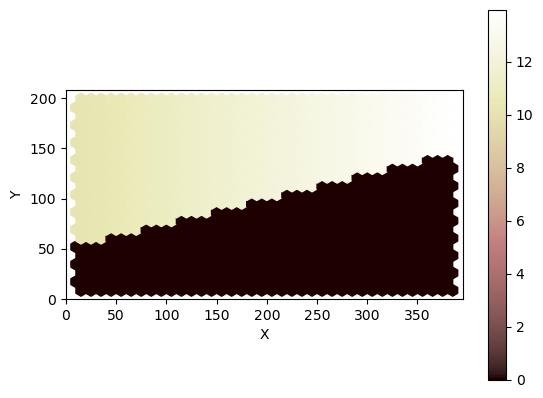

In [23]:
fault_trace_y = 50.0 + 0.25 * mg.x_of_node
z[mg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]
)
imshow_grid(mg, "topographic__elevation")

And we can use the same code as before to create a diffusion model!

Landlab supports multiple grid types. You can read more about them [here](https://landlab.readthedocs.io/en/latest/reference/grid/index.html).

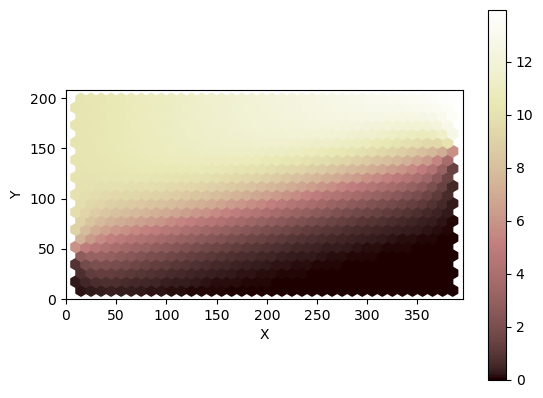

In [24]:
qs = mg.add_zeros("sediment_flux", at="link")
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt
imshow_grid(mg, "topographic__elevation")

## Part 3: Landlab Components

Finally we will use a Landlab component, called the LinearDiffuser [link to its documentation](https://landlab.readthedocs.io/en/latest/reference/components/diffusion.html).

Landlab was designed to have many of the utilities like `calc_grad_at_link`, and `calc_flux_divergence_at_node` to help you make your own models. Sometimes, however, you may use such a model over and over and over. Then it is nice to be able to put it in its own python class with a standard interface. 

This is what a Landlab Component is. 

There is a whole [tutorial on components](../component_tutorial/component_tutorial.ipynb) and a [page on the User Guide](https://landlab.readthedocs.io/en/latest/user_guide/components.html). For now we will just show you what the prior example looks like if we use the LinearDiffuser. 

First we import it, set up the grid, and uplift our fault block. 

In [25]:
from landlab.components import LinearDiffuser

mg = HexModelGrid((25, 40), 10, node_layout="rect")
z = mg.add_zeros("topographic__elevation", at="node")
fault_trace_y = 50.0 + 0.25 * mg.x_of_node
z[mg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]
)

Next we instantiate a LinearDiffuser. We have to tell the component what value to use for the diffusivity. 

In [28]:
D = 0.05
ld = LinearDiffuser(mg, linear_diffusivity=D)

Finally we run the component forward in time and plot. Like many Landlab components, the LinearDiffuser has a method called "run_one_step" that takes one input, the timestep dt. Calling this method runs the LinearDiffuser forward in time by an increment dt. 

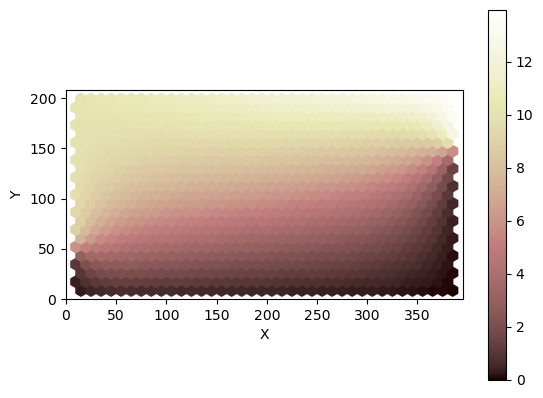

In [29]:
for i in range(25):
    ld.run_one_step(dt)
imshow_grid(mg, "topographic__elevation")

Congratulations on making it to the end of this tutorial!

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>